In [1]:
# some imports
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"


# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"


# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.rc('font', size=12)
plt.rc('figure', figsize = (12, 5))

# Settings for the visualizations
#import seaborn as sns
#sns.set_style("whitegrid")
#sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2,'font.family': [u'times']})

import pandas as pd
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 50)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
# Others
import cv2
import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split

 ## Import data

In [2]:
# Paths
X_train_path = './dataset/train/train/train/'
X_test_path = './dataset/test/test/test/'
dataset_csv = './dataset/train.txt'
dataset_train = './dataset/train/train'
dataset_test = './dataset/test/test'

In [3]:
_STOP = 1000
def preprocess(img_paths,dataset_path,preprocess_img_method = None):
    print("loading data")
    data = []
    stop = 0
    for img_path in tqdm.tqdm(img_paths):
        path = os.path.realpath(os.path.join(dataset_path,img_path[1:]))
        img = cv2.imread(path)
        if preprocess_img_method:
            img = preprocess_img_method(img)
        else:
            # img = cv2.merge([img,img,img])
            img = img / 255 #normalize
        img = cv2.resize(img,(224,224),cv2.INTER_AREA)
        data.append(img)
        stop += 1
        if(stop == _STOP):
            break
    print("loading data done")
    return data

def preprocess_img_vgg(img):
    return preprocess_input(img)


In [4]:
df = pd.read_csv(dataset_csv, delimiter='\ ', header=None)
y_train_full = np.array(df[1])
img_paths = df[0]
X_train_full = preprocess(df[0], dataset_train,preprocess_img_method=preprocess_img_vgg)
X_train_full= np.stack(X_train_full)

C:\ProgramData\Anaconda3\envs\tfgpu\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


loading data


  7%|▋         | 999/15000 [00:00<00:13, 1075.53it/s]


loading data done


In [5]:
print(max(y_train_full))

29


In [6]:
# Split dataset
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full[:_STOP], random_state=42)
X_train = X_train.astype("float64")
X_valid = X_valid.astype("float64")
y_train = y_train.astype("float64")
y_valid = y_valid.astype("float64")

In [7]:
print(X_train[0].shape)

(224, 224, 3)


In [8]:
print(len(X_train))
print(len(y_train))
print(len(X_valid))
print(len(y_valid))

750
750
250
250


In [16]:
print(len(X_train))
print(X_train[0].shape)
print(X_train.dtype)
print(type(X_train))
print(X_train.shape)
print(type(X_train[0]))

750
(224, 224, 3)
float64
<class 'numpy.ndarray'>
(750, 224, 224, 3)
<class 'numpy.ndarray'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


28.0


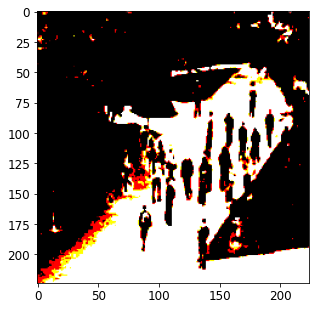

In [17]:
print(y_train[0])
plt.imshow(X_train[0], cmap=None)


## Model

In [18]:
base_model = tf.keras.applications.vgg16.VGG16(include_top=True,weights='imagenet',input_tensor=None,input_shape=(224,224,3),pooling=None,classifier_activation='softmax')

In [18]:
# base_model.add(tf.keras.layers.Flatten(name='flatten')(base_model.output))
# x = tf.keras.layers.Flatten(name='flatten')(base_model)
# x = tf.keras.layers.Dense(4096, activation='relu', name='fc1')(x)
# x = tf.keras.layers.Dense(4096, activation='relu', name='fc2')(x)
# x = tf.keras.layers.Dense(classes, activation='softmax', name='predictions')(x)
# model = keras.models.Model(inputs=base_model.input, outputs=x)
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [19]:
no_classes = max(y_train_full)
for layer in base_model.layers:
    layer.trainable = False
last_layer = base_model.get_layer('fc2').output
out = tf.keras.layers.Flatten(name="flatten1")(last_layer)
out = tf.keras.layers.Dense(128, activation='relu', name='fc3')(out)
out = tf.keras.layers.Dropout(0.5)(out)
out = tf.keras.layers.Dense(no_classes, activation='softmax', name='prediction')(out)
model = tf.keras.models.Model(inputs=base_model.input, outputs=out)

In [20]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [21]:
optimizer = tf.keras.optimizers.Nadam(lr=0.02, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004) # the default lr is 1e-3
model.compile(loss="mse", optimizer=optimizer,
metrics=['mse'])

In [22]:
history = model.fit(X_train, y_train, epochs=16,
validation_data=(X_valid, y_valid))

Epoch 1/16
24/24 [==============================] - 7s 290ms/step - loss: 278.7298 - mse: 278.7298 - val_loss: 261.9850 - val_mse: 261.9850

KeyboardInterrupt: 